In [17]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import pytensor as pt


In [2]:

data = pd.read_csv('statcast_data/2023.csv')

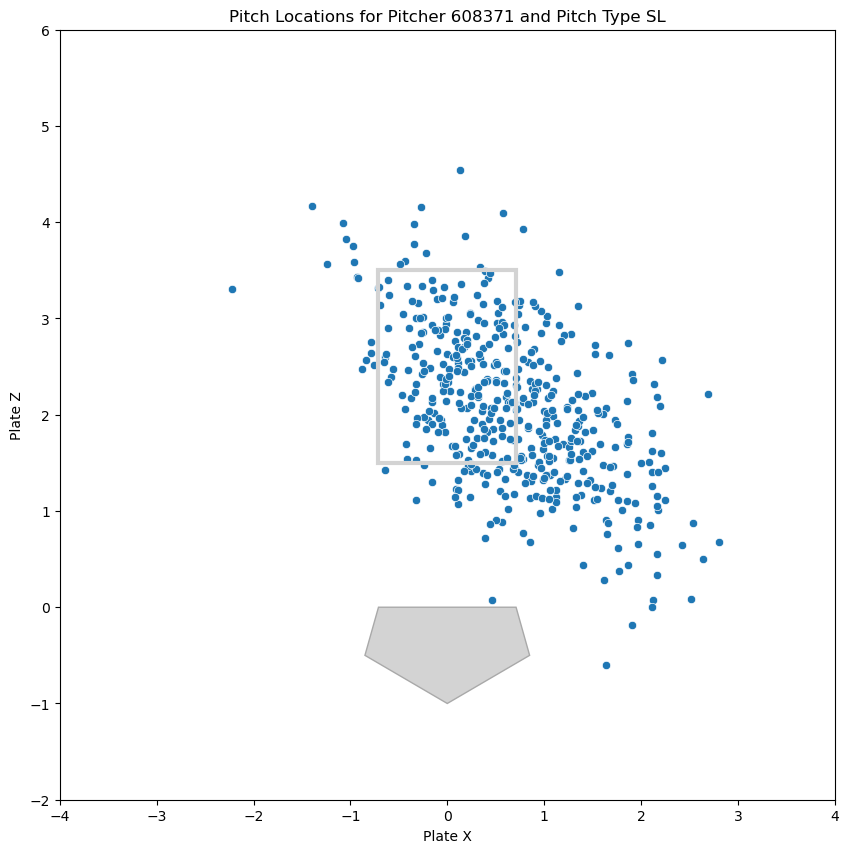

In [3]:
# Filter data for specific pitcher and pitch type
sims_data = data[(data['pitcher'] == 608371) & (data['pitch_type'] == 'SL')]

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=sims_data, x='plate_x', y='plate_z', ax=ax)
plt.title('Pitch Locations for Pitcher 608371 and Pitch Type SL')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.xlim(-4, 4)
plt.ylim(-2, 6)

# add home plate to plot 
home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
ax.add_patch(patches.Polygon(home_plate_coords,
                                edgecolor = 'darkgray',
                                facecolor = 'lightgray',
                                zorder = 2))

# add strike zone to plot, technically the y coords can vary by batter
ax.add_patch(patches.Rectangle((-0.71, 1.5), 2*0.71, 2,
                edgecolor = 'lightgray',
                fill=False,
                lw=3,
                zorder = 2))
plt.show()


In [4]:
called_strikes_balls = data.loc[data['description'].isin(['ball', 'called_strike'])]

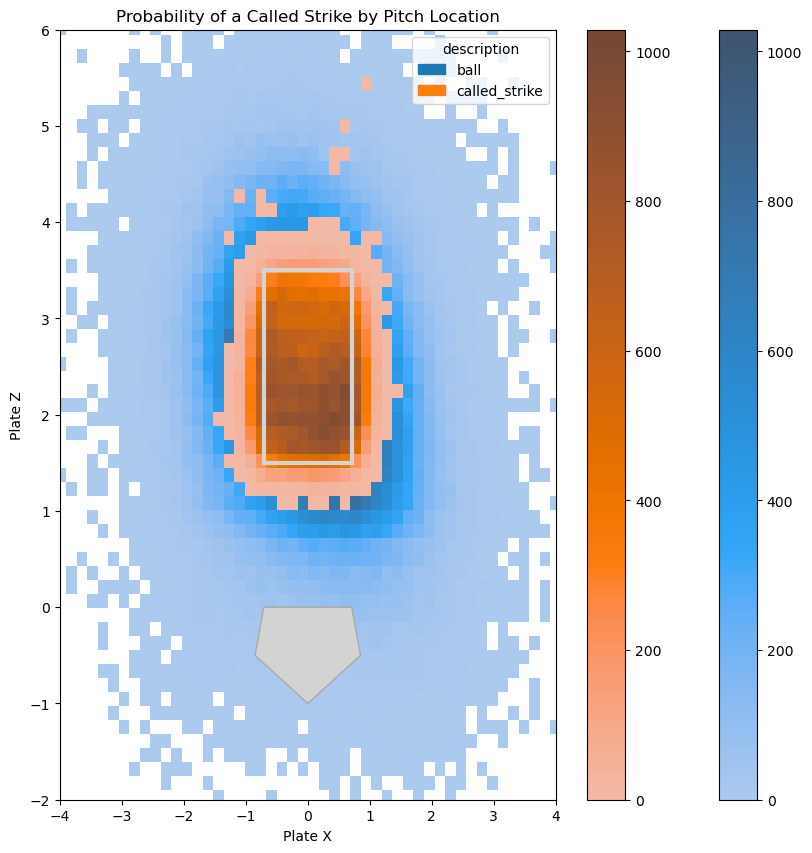

In [5]:
from matplotlib import patches
# Assuming 'description' is a column where 'called_strike' indicates a strike
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=called_strikes_balls, x='plate_x', y='plate_z', hue='description', bins=100, cbar=True, ax = ax)
plt.title('Probability of a Called Strike by Pitch Location')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.xlim(-4, 4)
plt.ylim(-2, 6)

# add home plate to plot 
home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
ax.add_patch(patches.Polygon(home_plate_coords,
                                edgecolor = 'darkgray',
                                facecolor = 'lightgray',
                                zorder = 2))

# add strike zone to plot, technically the y coords can vary by batter
ax.add_patch(patches.Rectangle((-0.71, 1.5), 2*0.71, 2,
                edgecolor = 'lightgray',
                fill=False,
                lw=3,
                zorder = 2))
plt.show()

In [6]:
data['sz_top'].mean()

3.3587962701420335

In [7]:
data['sz_bot'].mean()

1.5945601448577302

In [8]:
data['plate_x'].mean()

0.03654096655634706

In [9]:
pitcher_counts = data['pitcher'].value_counts()
data = data[data['pitcher'].isin(pitcher_counts[pitcher_counts > 100].index)]
data = data.loc[data['pitch_type'].isin(['SL'])]

In [10]:
len(data)

108134

In [11]:
data['stand'] = (data['stand'] == 'L').astype(int)
data['p_throws'] = (data['p_throws'] == 'L').astype(int)

In [12]:
num_pitchers = data['pitcher'].nunique()

In [13]:
data = data[['pitcher', 'plate_x', 'plate_z', 'stand', 'p_throws', 'pitch_type', 'balls', 'strikes']]
data.head()


,pitcher,plate_x,plate_z,stand,p_throws,pitch_type,balls,strikes
2,641360,0.12,3.22,0,0,SL,0,0
53,640451,2.62,-0.57,0,0,SL,0,0
74,676130,0.04,2.75,0,0,SL,1,1
76,676130,1.49,0.37,0,0,SL,0,0
80,666168,-0.08,3.09,1,0,SL,1,2


In [14]:
data = data.dropna()

In [15]:
pitcher_categories = data['pitcher'].astype('category')
pitcher_idx = pitcher_categories.cat.codes.values
pitcher_id_to_idx = {id: idx for idx, id in enumerate(pitcher_categories.cat.categories)}
stand = data['stand'].values
p_throws = data['p_throws'].values
balls = data['balls'].values
strikes = data['strikes'].values
observed_x = data['plate_x'].values
observed_z = data['plate_z'].values
obs_sd_x = np.std(observed_x)
obs_sd_z = np.std(observed_z)


In [37]:

# with pm.Model() as model:
#     # Hyperpriors
#     mu_x = pm.Normal('mu_x', 0, 5)
#     mu_z = pm.Normal('mu_z', 2.5, 5)
#     sigma_x = pm.HalfNormal('sigma_x', 5)
#     sigma_z = pm.HalfNormal('sigma_z', 5)
    
#     # Priors for each pitcher
#     pitcher_mu_x = pm.Normal('pitcher_mu_x', mu_x, sigma_x, shape=num_pitchers)
#     pitcher_mu_z = pm.Normal('pitcher_mu_z', mu_z, sigma_z, shape=num_pitchers)

#     # Covariate coefficients
#     beta_stand_x = pm.Normal('beta_stand_x', 0, 4)
#     beta_stand_z = pm.Normal('beta_stand_z', 0, 4)
#     beta_throw_x = pm.Normal('beta_throw_x', 0, 4)
#     beta_throw_z = pm.Normal('beta_throw_z', 0, 4)
#     beta_balls_x = pm.Normal('beta_balls_x', 0, 4)
#     beta_balls_z = pm.Normal('beta_balls_z', 0, 4)
#     beta_strikes_x = pm.Normal('beta_strikes_x', 0, 4)
#     beta_strikes_z = pm.Normal('beta_strikes_z', 0, 4)

#     # Priors for standard deviations
#     sd_x = pm.HalfNormal('sd_x', 5)
#     sd_z = pm.HalfNormal('sd_z', 5)

#     # Linear model for means
#     mu_observed_x = (pitcher_mu_x[pitcher_idx] + 
#                     beta_stand_x * stand +
#                     beta_throw_x * p_throws + 
#                     beta_balls_x * balls + 
#                     beta_strikes_x * strikes)

#     mu_observed_z = (pitcher_mu_z[pitcher_idx] + 
#                     beta_stand_z * stand +
#                     beta_throw_z * p_throws +
#                     beta_balls_z * balls + 
#                     beta_strikes_z * strikes)

#     # Likelihood
#     likelihood_x = pm.Normal('likelihood_x', mu_observed_x, sd_x, observed=observed_x)
#     likelihood_z = pm.Normal('likelihood_z', mu_observed_z, sd_z, observed=observed_z)

#     # Sample
#     trace = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu_x, mu_z, sigma_x, sigma_z, pitcher_mu_x, pitcher_mu_z, beta_stand_x, beta_stand_z, beta_throw_x, beta_throw_z, beta_balls_x, beta_balls_z, beta_strikes_x, beta_strikes_z, sd_x, sd_z]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 788 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


multivariate normal model

In [24]:
with pm.Model() as model:
    # Hyperpriors
    mu = pm.Normal('mu', 0, 5, shape=2)
    sigma = pm.HalfNormal('sigma', 5, shape=2)
    
    # Priors for each pitcher
    pitcher_mu = pm.Normal('pitcher_mu', mu, sigma, shape=(num_pitchers, 2))

    # Covariate coefficients
    beta_stand = pm.Normal('beta_stand', 0, 4, shape=2)
    beta_throw = pm.Normal('beta_throw', 0, 4, shape=2)
    beta_balls = pm.Normal('beta_balls', 0, 4, shape=2)
    beta_strikes = pm.Normal('beta_strikes', 0, 4, shape=2)

    # Priors for standard deviations
    sd = pm.HalfNormal('sd', 5, shape=2)

    sd_squared = np.diag(sd.eval()**2)  # Create a diagonal matrix using NumPy
    cov = pm.Data('cov', sd_squared)
    
    # Linear model for means
    mu_observed = (pitcher_mu[pitcher_idx] + 
                   beta_stand * stand +
                   beta_throw * p_throws + 
                   beta_balls * balls + 
                   beta_strikes * strikes)

    # Likelihood
    likelihood = pm.MvNormal('likelihood', mu_observed, cov, observed=np.stack((observed_x, observed_z), axis=-1))

    # Sample
    trace = pm.sample(2000)

c:\Users\wampl\anaconda3\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


ValueError: Incompatible Elemwise input shapes [(2,), (108070,)]

In [23]:
print(trace.posterior.data_vars)

Data variables:
    mu_x            (chain, draw) float64 0.4994 0.4721 0.4892 ... 0.4837 0.4801
    mu_z            (chain, draw) float64 2.044 2.022 2.026 ... 2.024 2.018
    pitcher_mu_x    (chain, draw, pitcher_mu_x_dim_0) float64 0.607 ... 0.6104
    pitcher_mu_z    (chain, draw, pitcher_mu_z_dim_0) float64 1.737 ... 1.762
    beta_stand_x    (chain, draw) float64 -0.3747 -0.3708 ... -0.3682 -0.3718
    beta_stand_z    (chain, draw) float64 0.008324 0.01512 ... 0.006008 0.01407
    beta_throw_x    (chain, draw) float64 -0.7818 -0.8017 ... -0.7924 -0.8057
    beta_throw_z    (chain, draw) float64 -0.002912 0.02049 ... 0.01445 0.01106
    beta_balls_x    (chain, draw) float64 -0.05649 -0.05629 ... -0.05286
    beta_balls_z    (chain, draw) float64 0.1075 0.1074 0.1087 ... 0.1064 0.1073
    beta_strikes_x  (chain, draw) float64 0.1108 0.1124 0.106 ... 0.1094 0.1056
    beta_strikes_z  (chain, draw) float64 -0.2211 -0.2183 ... -0.2153 -0.2195
    sigma_x         (chain, draw) float64 

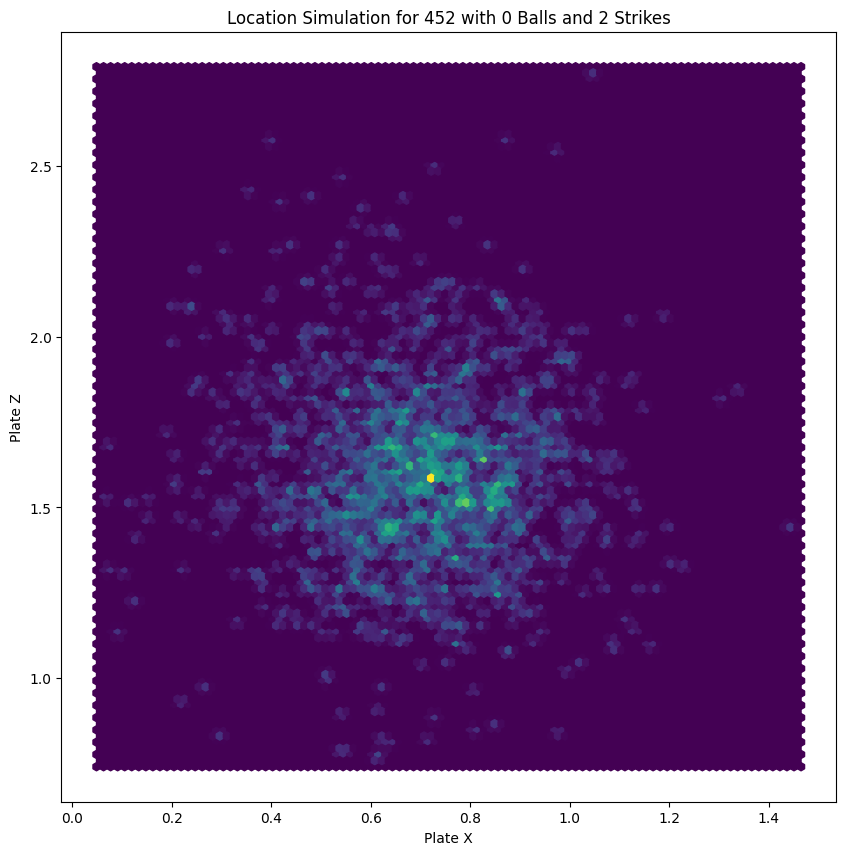

In [38]:

import matplotlib.pyplot as plt
  # Replace with the specific pitcher's name
specific_pitcher_idx = 141

simulated_x = trace.posterior['pitcher_mu_x'][:, specific_pitcher_idx] + trace.posterior['beta_balls_x'] * 0 + trace.posterior['beta_strikes_x'] * 2
simulated_z = trace.posterior['pitcher_mu_z'][:, specific_pitcher_idx] + trace.posterior['beta_balls_z'] * 0 + trace.posterior['beta_strikes_z'] * 2

plt.figure(figsize=(10, 10))
plt.hexbin(x=simulated_x, y=simulated_z)
plt.title(f'Location Simulation for {452} with 0 Balls and 2 Strikes')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.show()




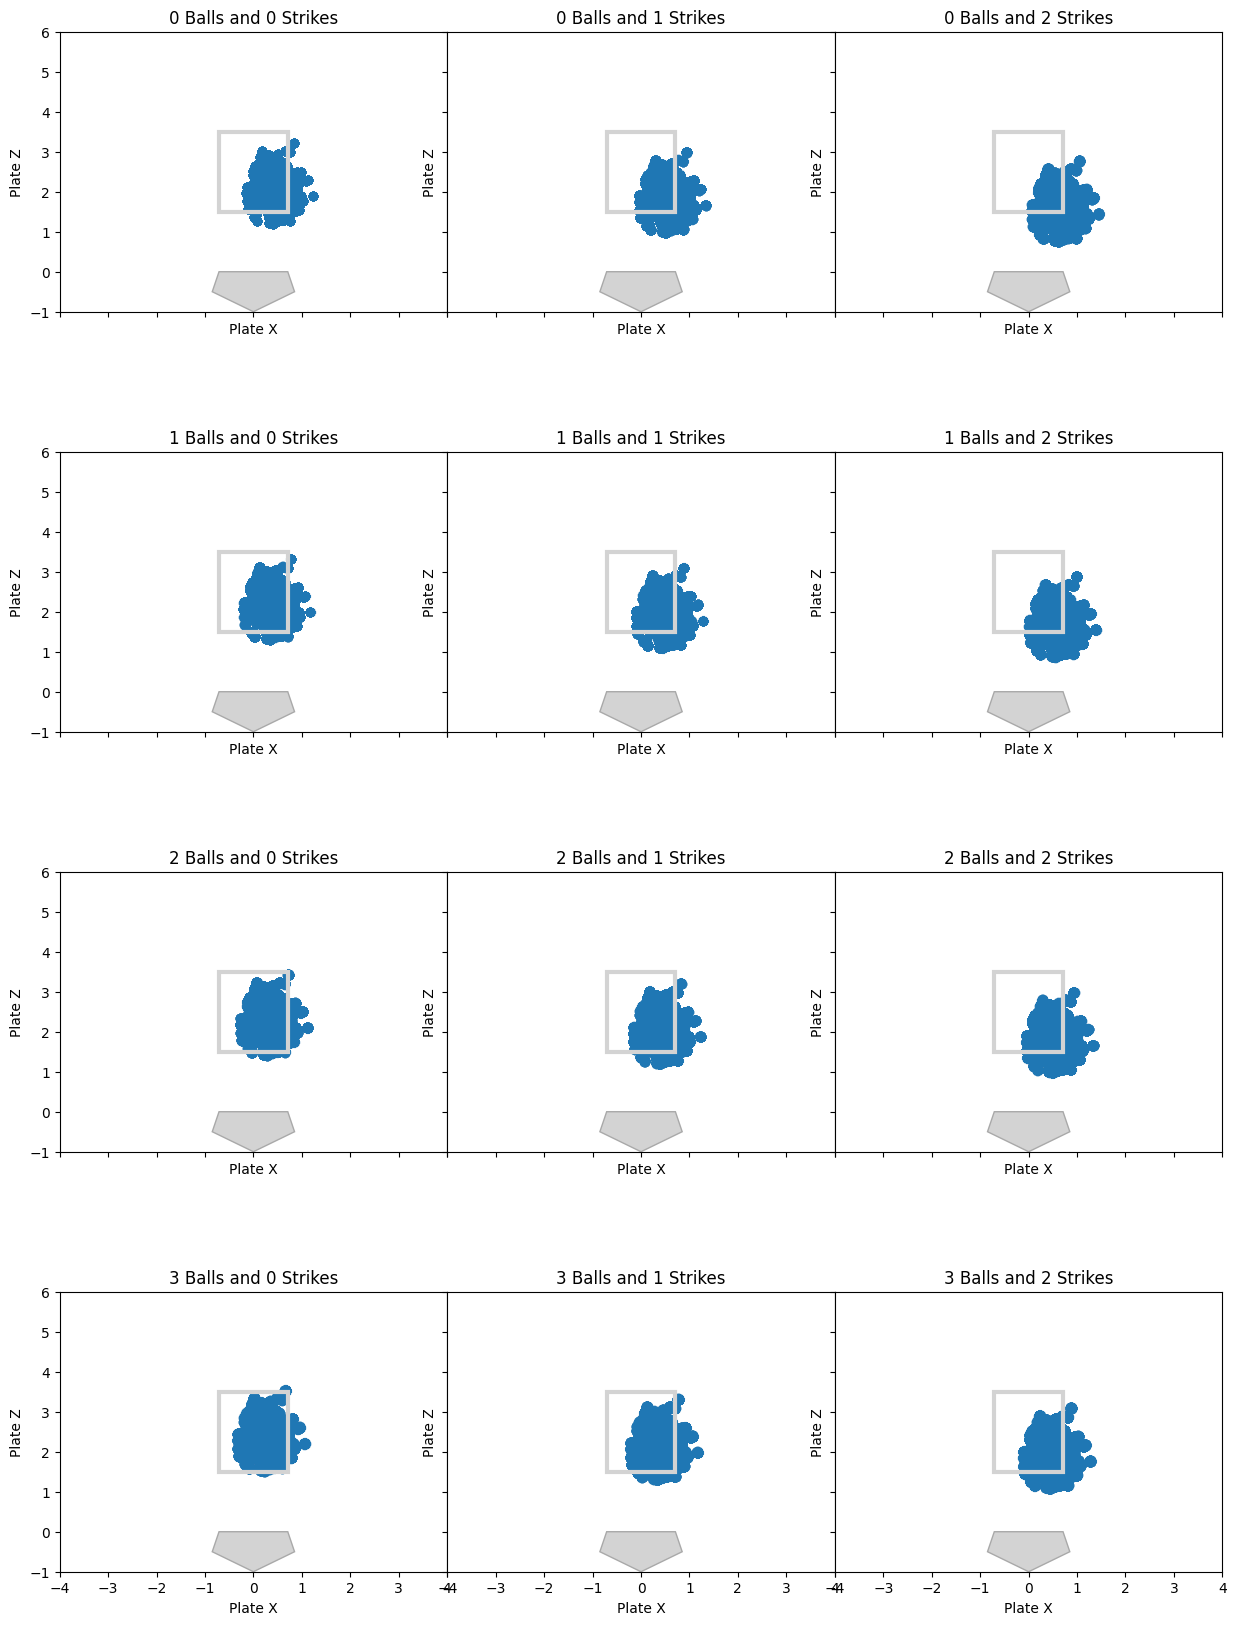

In [39]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharex=True, sharey=True)
fig.subplots_adjust(hspace = 0.5, wspace=.001)
axs = axs.ravel()

home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]

for i in range(4):
    for j in range(3):
        simulated_x = trace.posterior['pitcher_mu_x'][:, specific_pitcher_idx] + trace.posterior['beta_balls_x'] * i + trace.posterior['beta_strikes_x'] * j \
            + trace.posterior['beta_stand_x'] * 0 + trace.posterior['beta_throw_x'] * 0
        simulated_z = trace.posterior['pitcher_mu_z'][:, specific_pitcher_idx] + trace.posterior['beta_balls_z'] * i + trace.posterior['beta_strikes_z'] * j \
            + trace.posterior['beta_stand_z'] * 0 + trace.posterior['beta_throw_z'] * 0
        axs[3*i+j].scatter(x=simulated_x, y=simulated_z, alpha=0.1)
        axs[3*i+j].set_title(f'{i} Balls and {j} Strikes')
        axs[3*i+j].set_xlabel('Plate X')
        axs[3*i+j].set_ylabel('Plate Z')

        # Add home plate to plot
        axs[3*i+j].add_patch(patches.Polygon(home_plate_coords,
                                edgecolor = 'darkgray',
                                facecolor = 'lightgray',
                                zorder = 2))

        # Add strike zone to plot
        axs[3*i+j].add_patch(patches.Rectangle((-0.71, 1.5), 2*0.71, 2,
                edgecolor = 'lightgray',
                fill=False,
                lw=3,
                zorder = 2))

plt.xlim(-4, 4)
plt.ylim(-1, 6)
plt.show()

In [28]:
pitcher_id_to_idx[608371]

141